# Market Analysis with Integrated Ultra-supercritical Power Plant Model: Pricetaker Assumption

Author: Naresh Susarla (naresh.susarla@netl.doe.gov)

This notebook presents a market analysis considering the pricetaker assumption for the integrated system of ultra-supercritical power plant and Solar salt as the storage fluid in thermal energy storage system. The electricity prices or LMP (locational marginal prices) are given and remain constant through the assumed time horizon. The prices used in this study are obtained from a synthetic database, i.e. RTS-GMLC.

To start this analysis, first import all packages and libraries required.

In [1]:
from pyomo.environ import Param, Objective, Expression, SolverFactory, value
import numpy as np
from dispatches.models.fossil_case.ultra_supercritical_plant.storage.\
    multiperiod_integrated_storage_usc import create_multiperiod_usc_model

# For plots
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

Get the LMP data from a database or define a list of electricity prices. In this analysis, we define a list and populate it with custom electricity prices. This list is named `price`.

In [2]:
# Select LMP source data and scaling factor
use_rts_data = False
use_mod_rts_data = True
if use_rts_data:
    print('>>>>>> Using RTS lmp data')
    with open('rts_results_all_prices_base_case.npy', 'rb') as f:
        price = np.load(f)
elif use_mod_rts_data:
    price = [22.9684, 21.1168, 20.4, 20.419,
             20.419, 21.2877, 23.07, 25,
             18.4634, 0, 0, 0,
             0, 0, 0, 0,
             19.0342, 23.07, 200, 200,
             200, 200, 200, 200]
else:
    print('>>>>>> Using NREL lmp data')
    price = np.load("nrel_scenario_average_hourly.npy")

if use_rts_data:
    lmp = price[0:number_hours].tolist()
elif use_mod_rts_data:
    lmp = price

Define the time horizon and period for the market analysis using the pricetaker assumption and add the initial status of the Solar salt storage tank.

In [3]:
# Add number of days and hours per week
ndays = 1
nweeks = 1
number_hours = 24 * ndays
n_time_points = nweeks * number_hours

# Add status for storage tanks in kg
tank_status = "hot_empty"
tank_min = 1
tank_max = 6739292

Construct a time-indexed multiperiod model using the multiperiod method with the integrated ultra-supercritical power plant. During this step, the model is initialized for each time period.

In [4]:
# Create the multiperiod model object
multiperiod_usc = create_multiperiod_usc_model(
    n_time_points=n_time_points, pmin=None, pmax=None
)

# Retrieve pyomo model and active time blocks
m = multiperiod_usc.pyomo_model
blks = multiperiod_usc.get_active_process_blocks()

>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time period
>>> Creating USC model and initialization for each time

Use the LMP data from the `price` list above to assign the electricity prices to each time period. Also, include revenue and operating cost functions to calculate a total cost.

In [5]:
count = 0
for blk in blks:
    blk_usc_mp = blk.usc_mp
    blk.lmp_signal = Param(default=0, mutable=True)
    blk.revenue = lmp[count]*blk.usc_mp.fs.net_power
    blk.operating_cost = Expression(
        expr=(
            (blk_usc_mp.fs.operating_cost
             + blk_usc_mp.fs.plant_fixed_operating_cost
             + blk_usc_mp.fs.plant_variable_operating_cost) / (365 * 24)
        )
    )
    blk.cost = Expression(expr=-(blk.revenue - blk.operating_cost))
    count += 1

Add the total cost expression as the objective function.

In [6]:
m.obj = Objective(expr=sum([blk.cost for blk in blks]))

Add initial state for the two linking variables in the model: the Solar salt tank for different scenarios and the power.

In [7]:
# Initial state for Solar salt tank for differrent tank scenarios:"hot_empty","hot_full","hot_half_full"
if tank_status == "hot_empty":
    blks[0].usc_mp.previous_salt_inventory_hot.fix(1103053.48)
    blks[0].usc_mp.previous_salt_inventory_cold.fix(tank_max-1103053.48)
elif tank_status == "half_full":
    blks[0].usc_mp.previous_salt_inventory_hot.fix(tank_max/2)
    blks[0].usc_mp.previous_salt_inventory_cold.fix(tank_max/2)
elif tank_status == "hot_full":
    blks[0].usc_mp.previous_salt_inventory_hot.fix(tank_max-tank_min)
    blks[0].usc_mp.previous_salt_inventory_cold.fix(tank_min)
else:
    print("Unrecognized scenario! Try hot_empty, hot_full, or half_full")

# Initial state for power linking variable
blks[0].usc_mp.previous_power.fix(447.66)

Finally, solve the entire multi-period model and save the results in lists to be used later to plot the results.

In [8]:
# Declare NLP solver
opt = SolverFactory('ipopt')

# Declare lists to save results
hot_tank_level = []
cold_tank_level = []
net_power = []
hxc_duty = []
hxd_duty = []
for week in range(nweeks):
    print()
    print(">>>>>> Solving for week {}: {} hours of operation in {} day(s) "
          .format(week + 1, number_hours, ndays))

    # Solve the multi-period model
    opt.solve(m, tee=True)

    hot_tank_level.append([(value(blks[i].usc_mp.salt_inventory_hot)) * 1e-3
                           for i in range(n_time_points)])
    cold_tank_level.append([(value(blks[i].usc_mp.salt_inventory_cold)) * 1e-3
                            for i in range(n_time_points)])
    net_power.append([value(blks[i].usc_mp.fs.net_power)
                      for i in range(n_time_points)])
    hxc_duty.append([value(blks[i].usc_mp.fs.hxc.heat_duty[0]) * 1e-6
                     for i in range(n_time_points)])
    hxd_duty.append([value(blks[i].usc_mp.fs.hxd.heat_duty[0]) * 1e-6
                     for i in range(n_time_points)])


>>>>>> Solving for week 1: 24 hours of operation in 1 day(s) 
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran co

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -4.5459986e+05 8.63e+05 2.62e-01  -1.0 2.24e+07 -15.1 1.00e+00 4.00e-01h  1
  71 -4.5459964e+05 1.72e+05 3.58e-02  -1.0 3.94e+06 -14.7 1.00e+00 1.00e+00h  1
  72 -4.5460169e+05 3.55e+06 3.98e-01  -1.0 1.75e+07 -15.2 1.00e+00 1.00e+00h  1
  73 -4.5460339e+05 3.64e+05 7.96e-02  -1.0 7.50e+06 -14.8 1.00e+00 1.00e+00h  1
  74 -4.5460864e+05 1.12e+07 1.38e+00  -1.0 3.74e+07 -15.2 1.00e+00 8.51e-01h  1
  75 -4.5460624e+05 4.80e+06 6.25e-01  -1.0 1.92e+07    -  1.00e+00 1.00e+00h  1
  76 -4.5460938e+05 1.81e+06 1.95e-01  -1.0 1.10e+07    -  1.00e+00 1.00e+00h  1
  77 -4.5460958e+05 8.58e+04 2.33e-02  -1.0 4.17e+06    -  1.00e+00 1.00e+00h  1
  78 -4.5460960e+05 6.07e+02 8.30e-05  -1.0 2.43e+05    -  1.00e+00 1.00e+00h  1
  79 -4.5462293e+05 1.01e+05 1.85e+01  -2.5 3.69e+06    -  9.72e-01 5.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -4.5462888e+05 5.24e+04

Add maximum and minimum values for the power plant power production and storage heat duty. This is needed when plotting the results.

In [9]:
max_power = 436
max_power_storage = 30
max_power_total = max_power + max_power_storage
min_storage_heat_duty = 10
max_storage_heat_duty = 200

In Figure 1, plot the Solar salt levels in the storage tank for the entire time horizon.

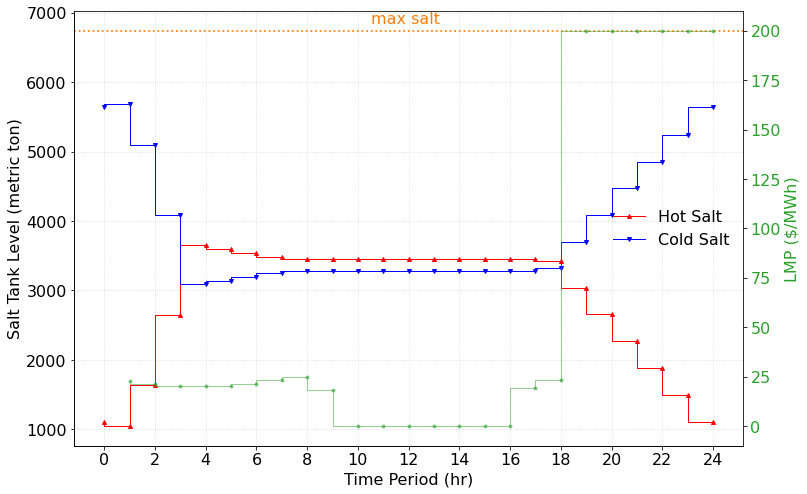

In [10]:
hours = np.arange(n_time_points * nweeks)
lmp_array = np.asarray(lmp[0:n_time_points])
hot_tank_array = np.asarray(hot_tank_level[0:nweeks]).flatten()
cold_tank_array = np.asarray(cold_tank_level[0:nweeks]).flatten()

# Convert array to list to include hot tank level at time zero
hot_tank_array0 = value(blks[0].usc_mp.previous_salt_inventory_hot) * 1e-3
cold_tank_array0 = value(blks[0].usc_mp.previous_salt_inventory_cold) * 1e-3
hours_list = hours.tolist() + [n_time_points]
hot_tank_list = [hot_tank_array0] + hot_tank_array.tolist()
cold_tank_list = [cold_tank_array0] + cold_tank_array.tolist()

# Declare settings for plot
font = {'size': 16}
plt.rc('font', **font)
fig1, ax1 = plt.subplots(figsize=(12, 8))
color = ['r', 'b', 'tab:green', 'k', 'tab:orange']

ax1.set_xlabel('Time Period (hr)')
ax1.set_ylabel('Salt Tank Level (metric ton)',
               color=color[3])
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.grid(linestyle=':', which='both',
         color='gray', alpha=0.30)
plt.axhline(tank_max * 1e-3, 
            ls=':', lw=1.75,
            color=color[4])
plt.text(n_time_points / 2 - 1.5,
         tank_max * 1e-3 + 100, 
         'max salt',
         color=color[4])
ax1.step(hours_list, hot_tank_list,
         marker='^', ms=4,
         lw=1, color=color[0], 
         label='Hot Salt')
ax1.step(hours_list, cold_tank_list,
         marker='v', ms=4,
         lw=1, color=color[1], 
         label='Cold Salt')
ax1.legend(loc="center right", frameon=False)
ax1.tick_params(axis='y')
ax1.set_xticks(np.arange(0, n_time_points * nweeks + 1, step=2))

ax2 = ax1.twinx()
ax2.set_ylabel('LMP ($/MWh)',
               color=color[2])
ax2.step([x + 1 for x in hours], lmp_array,
         marker='o', ms=3, alpha=0.5,
         ls='-', lw=1,
         color=color[2])
ax2.tick_params(axis='y',
                labelcolor=color[2])

In Figure 2, plot the operating profile of the power plant in terms of total power for the entire time horizon.

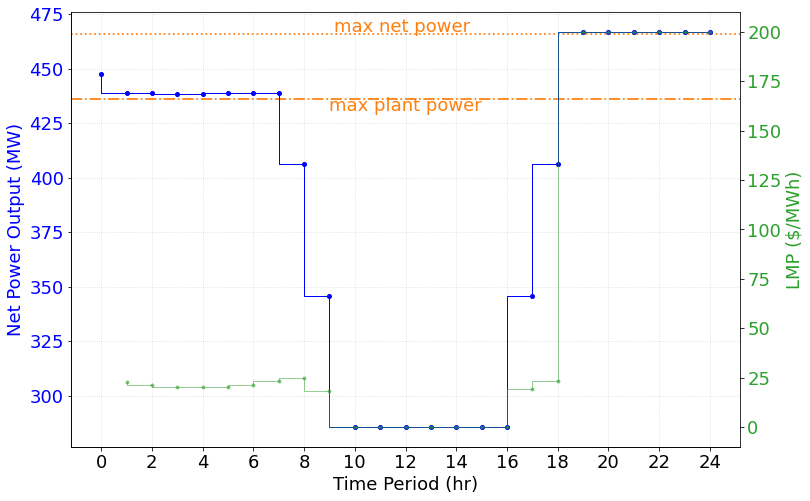

In [11]:
font = {'size': 18}
plt.rc('font', **font)

power_array = np.asarray(net_power[0:nweeks]).flatten()

# Convert array to list to include net power at time zero
power_array0 = value(blks[0].usc_mp.previous_power)
power_list = [power_array0] + power_array.tolist()

fig2, ax3 = plt.subplots(figsize=(12, 8))
ax3.set_xlabel('Time Period (hr)')
ax3.set_ylabel('Net Power Output (MW)',
               color=color[1])
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.grid(linestyle=':', which='both',
         color='gray', alpha=0.30)
plt.text(n_time_points / 2 - 3, max_power - 5.5,
         'max plant power',
         color=color[4])
plt.text(n_time_points / 2 - 2.8, max_power_total + 1,
         'max net power',
         color=color[4])
plt.axhline(max_power, 
            ls='-.', lw=1.75, 
            color=color[4])
plt.axhline(max_power_total, 
            ls=':', lw=1.75, 
            color=color[4])
ax3.step(hours_list, power_list,
         marker='o', ms=4,
         lw=1, color=color[1])
ax3.tick_params(axis='y',
                labelcolor=color[1])
ax3.set_xticks(np.arange(0, n_time_points * nweeks + 1, step=2))

ax4 = ax3.twinx()
ax4.set_ylabel('LMP ($/MWh)',
               color=color[2])
ax4.step([x + 1 for x in hours], lmp_array,
         marker='o', ms=3, alpha=0.5,
         ls='-', lw=1,
         color=color[2])
ax4.tick_params(axis='y',
                labelcolor=color[2])

In Figure 3, plot the storage heat exchanger operating profiles in terms of heat duties for the entire time horizon.

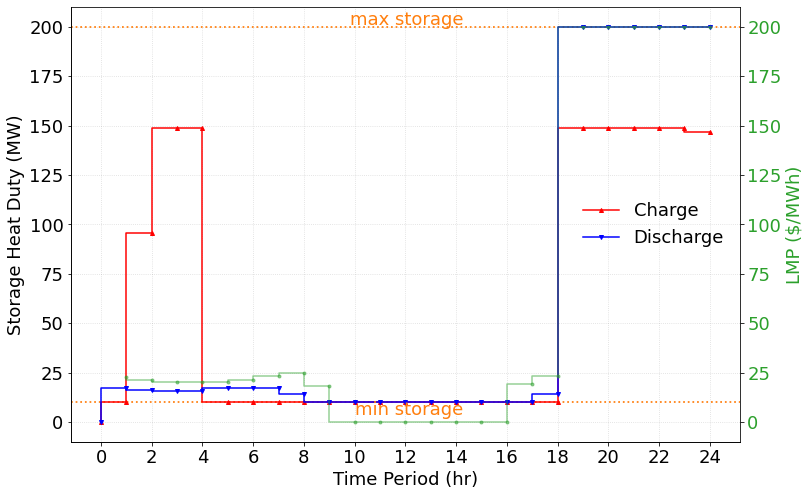

In [12]:
zero_point = True
hxc_array = np.asarray(hxc_duty[0:nweeks]).flatten()
hxd_array = np.asarray(hxd_duty[0:nweeks]).flatten()
hxc_duty0 = 0
hxc_duty_list = [hxc_duty0] + hxc_array.tolist()
hxd_duty0 = 0
hxd_duty_list = [hxd_duty0] + hxd_array.tolist()

fig3, ax5 = plt.subplots(figsize=(12, 8))
ax5.set_xlabel('Time Period (hr)')
ax5.set_ylabel('Storage Heat Duty (MW)',
               color=color[3])
ax5.spines["top"].set_visible(False)
ax5.spines["right"].set_visible(False)
ax5.grid(linestyle=':', which='both',
         color='gray', alpha=0.30)
plt.text(n_time_points / 2 - 2.2, 
         max_storage_heat_duty + 1,
         'max storage',
         color=color[4])
plt.text(n_time_points / 2 - 2, 
         min_storage_heat_duty - 6.5,
         'min storage',
         color=color[4])
plt.axhline(max_storage_heat_duty, 
            ls=':', lw=1.75,
            color=color[4])
plt.axhline(min_storage_heat_duty, 
            ls=':', lw=1.75,
            color=color[4])
if zero_point:
    ax5.step(hours_list, hxc_duty_list,
             marker='^', ms=4,
             color=color[0], label='Charge',)
    ax5.step(hours_list, hxd_duty_list,
             marker='v', ms=4,
             color=color[1], label='Discharge')
else:
    ax5.step([x + 1 for x in hours], hxc_array,
             marker='^', ms=4, lw=1,
             color=color[0], label='Charge')
    ax5.step([x + 1 for x in hours], hxd_array,
             marker='v', ms=4, lw=1,
             color=color[1], label='Discharge')
ax5.legend(loc="center right", frameon=False)
ax5.tick_params(axis='y',
                labelcolor=color[3])
ax5.set_xticks(np.arange(0, n_time_points * nweeks + 1, step=2))

ax6 = ax5.twinx()
ax6.set_ylabel('LMP ($/MWh)',
               color=color[2])
ax6.step([x + 1 for x in hours], lmp_array,
         marker='o', ms=3,
         alpha=0.5, ls='-',
         color=color[2])
ax6.tick_params(axis='y',
                labelcolor=color[2])